In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) 
import copy
import sys
import os

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)


from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *


/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**5
n_host = 200
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
causal_param_first_index = 4
outcome_function = lambda X, T, eps: 1 + 1 * X['X_0'] - 1 * X['X_1'] + 1 * X['X_2'] + 4 * T + 2* X['X_0']*T + 2* X['X_1']*T + 0* X['X_2']*T + eps 
std_true_y = 1 # Standard deviation for the true Y

X0 = np.random.beta(12, 3, size= n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions= {'X_0': X0, 'X_1': X1, 'X_2':X2}
d = 1 + len(x_distributions)*(power_x) + 1 + len(x_distributions)*(power_x_t)

p_assigned_to_host = lambda X, T, eps: sigmoid(1 + 2*X['X_0'] - X['X_1'] + 2*T + eps)
p_assigned_to_cand2 =  lambda X, T, eps: sigmoid(1 + 2*X['X_0'] - X['X_1'] + 2*T + eps)
# p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 - 2*X_0 + eps)

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
prior_mean = np.array([0, 1, 0, 0, 1, 0, 0, 0])
beta_0, sigma_0_sq,inv_cov_0 = prior_mean, sigma_rand_error**2,1/sigma_prior*np.eye(len(prior_mean)) 
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}

# Number of samples used to estimate outer expectation
n_samples_for_expectation = 50
m_samples_for_expectation = 1000

# Incorporating sqrt constraint into MCMC samples
n_mc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

In [4]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1 #n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


data_parameters = {'n_both_candidates_list': n_both_candidates_list, 'proportion':proportion, 'n_rct_before_split':n_rct_before_split, \
                   'x_distributions':x_distributions, 'p_assigned_to_cand2':p_assigned_to_cand2, 'p_assigned_to_host':p_assigned_to_host, \
                    'n_host':n_host, 'power_x':power_x, 'power_x_t':power_x_t, 'outcome_function':outcome_function, 'std_true_y':std_true_y, \
                     'causal_param_first_index':causal_param_first_index}

### 2. EIG closed form 

In [5]:
n_seeds= 3
plot_additional = True

text_l1 ='p_assigned_to_host=p_assigned_to_cand2, n_samples_for_expectation = 30,'
text_l2 = 'm_samples_for_expectation = 500, n_host = 200, sigma_prior = 1, sigma_rand_error = 1,'
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T  +eps'

In [6]:
if not plot_additional:
    dict_additional_plots_obs_closed_from = dict_additional_plots_caus_closed_from = {'complementary':0, 'twin': 0, 'twin_treated': 0, 'twin_untreated': 0}

else:
    exact_data = generate_exact_data_varying_sample_size(data_parameters, x_distributions)
    dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = linear_eig_closed_form_exact_datasets(exact_data, data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)

In [18]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []

for i in range (n_seeds):
    data = generate_data_varying_sample_size(data_parameters, x_distributions)
    EIG_obs_closed_form, EIG_caus_closed_form = linear_eig_closed_form_varying_sample_size(data, data_parameters, sigma_rand_error, prior_hyperparameters, n_mc, verbose=True)
    if len(EIG_obs_closed_form_across_seeds)==0:
        EIG_obs_closed_form_across_seeds= EIG_obs_closed_form
        EIG_caus_closed_form_across_seeds = EIG_caus_closed_form
    else:
        EIG_obs_closed_form_across_seeds = np.vstack((EIG_obs_closed_form_across_seeds, EIG_obs_closed_form))
        EIG_caus_closed_form_across_seeds = np.vstack((EIG_caus_closed_form_across_seeds, EIG_caus_closed_form))
    

0
For a sample size in complementary and host of 200
Percentage of treated in host: 73.0%
Percentage of treated in complementary: 39.5%
Percentage of treated in cand2: 73.0%
For a sample size in complementary and host of 500
Percentage of treated in host: 73.0%
Percentage of treated in complementary: 36.2%
Percentage of treated in cand2: 71.2%
For a sample size in complementary and host of 1000
Percentage of treated in host: 70.5%
Percentage of treated in complementary: 37.1%
Percentage of treated in cand2: 69.5%
1
For a sample size in complementary and host of 200
Percentage of treated in host: 73.0%
Percentage of treated in complementary: 39.5%
Percentage of treated in cand2: 73.0%
For a sample size in complementary and host of 500
Percentage of treated in host: 73.0%
Percentage of treated in complementary: 36.2%
Percentage of treated in cand2: 71.2%
For a sample size in complementary and host of 1000
Percentage of treated in host: 70.5%
Percentage of treated in complementary: 37.1%


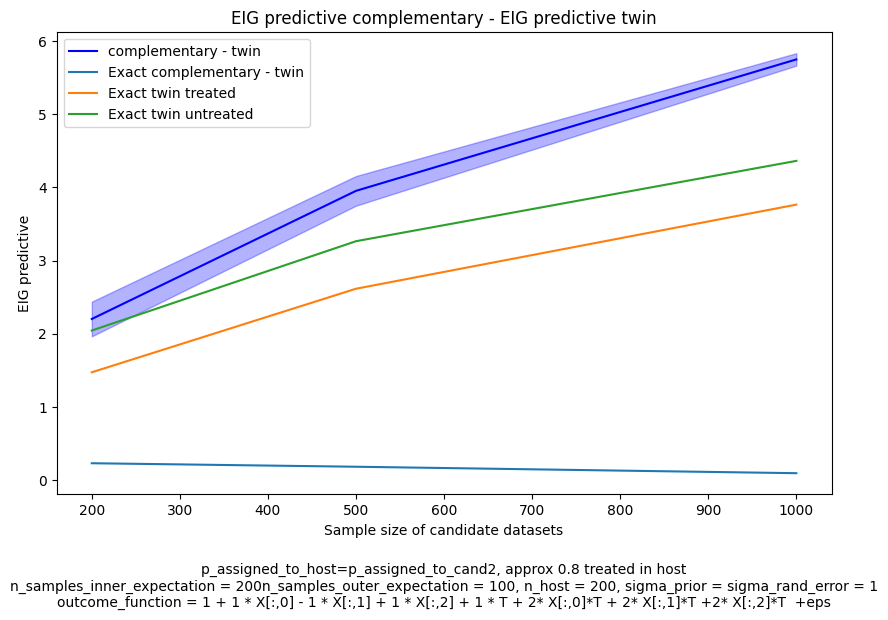

In [19]:
# path_obs_closed_form = '/Users/lucile/causal_info_gain/plots/eig_obs_closed_form'
path_obs_closed_form = 0

plot_array(dict_additional_plots_obs_closed_from, n_both_candidates_list, EIG_obs_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG predictive complementary - EIG predictive twin', save=path_obs_closed_form)

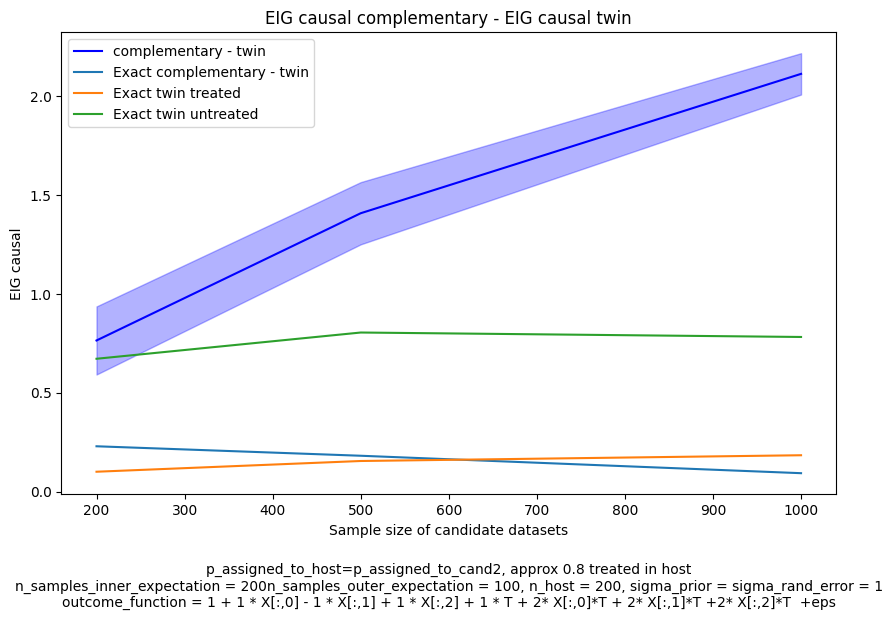

In [20]:
# path_caus_closed_form = '/Users/lucile/causal_info_gain/plots/eig_caus_closed_form'
path_caus_closed_form = 0

plot_array(dict_additional_plots_caus_closed_from, n_both_candidates_list, EIG_caus_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG causal complementary - EIG causal twin', save=path_caus_closed_form)

### 2. EIG from samples for varying sample sizes

In [21]:
n_samples_outer_expectation = 100
n_samples_inner_expectation = 200
n_causal_outer_exp = 100
n_causal_inner_exp = 200

sampling_parameters = {'n_samples_inner_expectation':n_samples_inner_expectation, 'n_samples_outer_expectation':n_samples_outer_expectation, \
                       'n_causal_inner_exp':n_causal_inner_exp, 'n_causal_outer_exp':n_causal_outer_exp}

In [22]:
plot_additional = True
if not plot_additional:
    dict_additional_plots_obs_from_samples = dict_additional_plots_caus_from_samples = {'complementary':0, 'twin': 0, 'twin_treated': 0, 'twin_untreated': 0}

else:
    dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = linear_eig_from_samples_exact_datasets(exact_data, data_parameters, prior_hyperparameters, n_mc, sampling_parameters)
    

In [23]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range (n_seeds):
    EIG_obs_samples, EIG_caus_samples = linear_eig_from_samples_varying_sample_size(data, data_parameters, prior_hyperparameters, sampling_parameters)
    if len(EIG_obs_samples_across_seeds)==0:
        EIG_obs_samples_across_seeds= EIG_obs_samples
        EIG_caus_samples_across_seeds = EIG_caus_samples
    else:
        EIG_obs_samples_across_seeds = np.vstack((EIG_obs_samples_across_seeds, EIG_obs_samples))
        EIG_caus_samples_across_seeds = np.vstack((EIG_caus_samples_across_seeds, EIG_caus_samples))

In [24]:
text_l1 ='p_assigned_to_host=p_assigned_to_cand2, approx 0.8 treated in host'
text_l2 = 'n_samples_inner_expectation = '+str(n_samples_inner_expectation)+ 'n_samples_outer_expectation = '+str(n_samples_outer_expectation)+', n_host = '+str(n_host)+', sigma_prior = sigma_rand_error = '+str(sigma_rand_error)
text_l4 = 'n_host = 200, sigma_prior = sigma_rand_error = 1, n_causal_inner_exp = '+str(n_causal_inner_exp) 

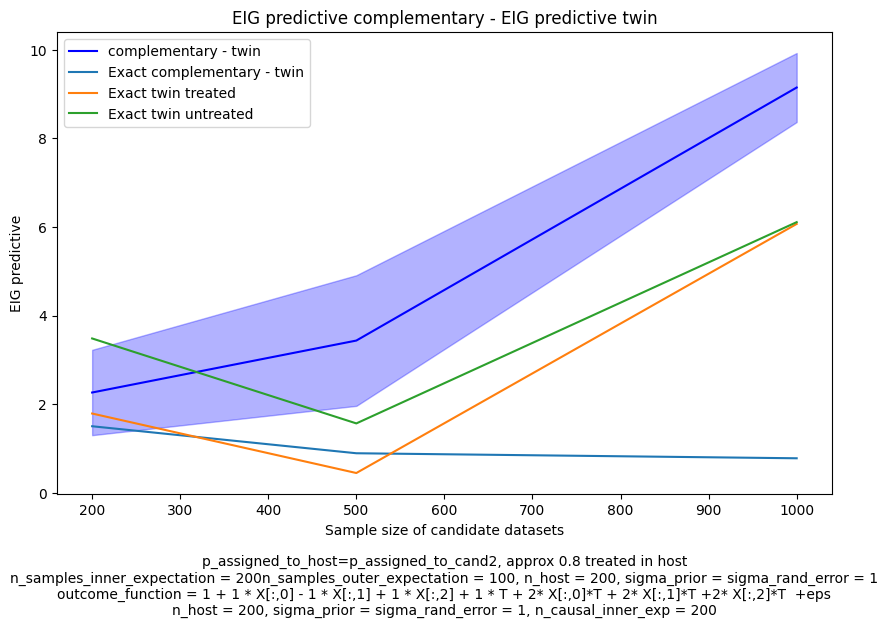

In [25]:
# path_obs_samples = '/Users/lucile/causal_info_gain/plots/eig_obs_samples'
path_obs_samples = 0

plot_array(dict_additional_plots_obs_from_samples, n_both_candidates_list, EIG_obs_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG predictive complementary - EIG predictive twin', save=path_obs_samples)

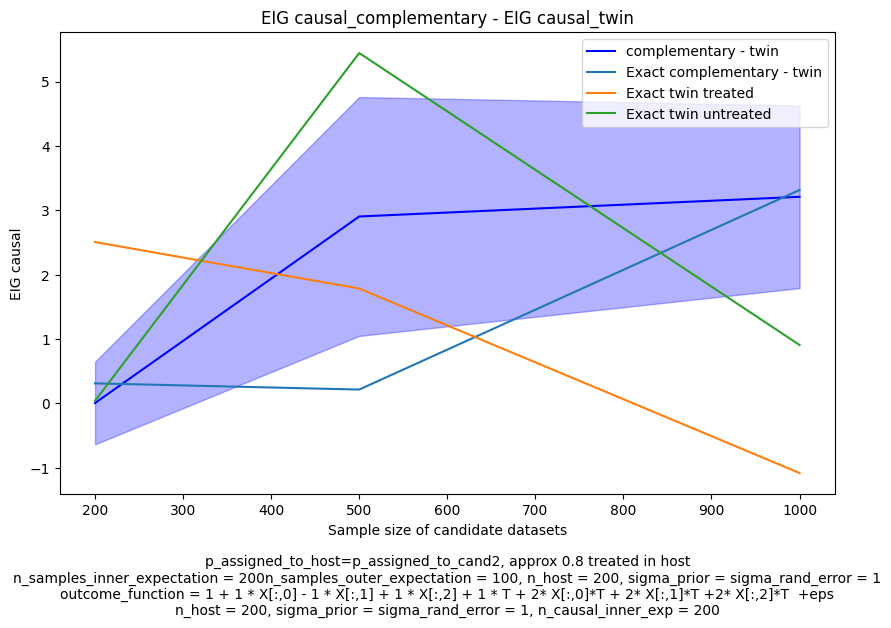

In [26]:
# path_caus_samples = '/Users/lucile/causal_info_gain/plots/eig_caus_samples'
path_caus_samples = 0

plot_array(dict_additional_plots_caus_from_samples, n_both_candidates_list, EIG_caus_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG causal_complementary - EIG causal_twin', save=path_caus_samples)

In [27]:
EIG_obs_closed_form_across_seeds0 = EIG_obs_closed_form_across_seeds
EIG_caus_closed_form_across_seeds0 = EIG_caus_closed_form_across_seeds
EIG_obs_samples_across_seeds0 = EIG_obs_samples_across_seeds
EIG_caus_samples_across_seeds0 = EIG_caus_samples_across_seeds